In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
participants_train = pd.read_csv('../data/participants_train.csv')
train_winners = pd.read_csv('../data/train_winners.csv')
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

In [3]:
df = participants_train.merge(right = champion_mastery,what is an imputerwhat is an imputer
                                on = ['summonerId', 'championId'])
                

In [4]:
df

,matchId,teamId,participantId,summonerId,summonerLevel,championName,championId,championLevel,championPoints,chestGranted,tokensEarned
0,0,100,1,0,303,Mordekaiser,82,6.0,61890.0,True,3.0
1,0,100,2,1,616,Sylas,517,5.0,37664.0,True,2.0
2,0,100,3,2,667,Lissandra,127,6.0,40303.0,True,1.0
3,0,100,4,3,860,Caitlyn,51,6.0,96304.0,True,3.0
4,0,100,5,4,325,Morgana,25,7.0,608721.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79995,7999,200,6,13979,595,Yorick,83,6.0,48037.0,False,1.0
79996,7999,200,7,39643,38,Volibear,106,1.0,135.0,False,0.0
79997,7999,200,8,5570,498,Anivia,34,7.0,49027.0,False,0.0
79998,7999,200,9,10228,733,Twitch,29,7.0,174089.0,True,0.0


We need to split up the df into single observations(1 row for each match) with columns representing team 100 stats and team 200 stats, then merge the match outcome column from train_winners.csv

Lets start with the aggregate sums for summonerLevel, championLevel, championPoints, and tokensEarned. Do this for each team 

In [5]:
df_array = np.array((df.groupby(['matchId','teamId'])
                           .sum(["summonerLevel", 'championLevel', 'championPoints', 'tokensEarned'])
                           .drop(columns=['participantId', 'summonerId', 'championId'])

                     ).unstack('teamId'))


In [6]:
df_array

array([[2.771000e+03, 2.089000e+03, 3.000000e+01, ..., 1.450310e+06,
        9.000000e+00, 2.000000e+00],
       [2.213000e+03, 1.585000e+03, 3.300000e+01, ..., 8.715830e+05,
        2.000000e+00, 0.000000e+00],
       [2.119000e+03, 1.070000e+03, 2.500000e+01, ..., 6.652510e+05,
        2.000000e+00, 0.000000e+00],
       ...,
       [1.558000e+03, 1.055000e+03, 2.900000e+01, ..., 1.203774e+06,
        2.000000e+00, 3.000000e+00],
       [1.881000e+03, 2.850000e+03, 2.600000e+01, ..., 7.036590e+05,
        0.000000e+00, 0.000000e+00],
       [2.461000e+03, 2.438000e+03, 2.600000e+01, ..., 3.019910e+05,
        4.000000e+00, 1.000000e+00]])

In [7]:
col_names = ['summonerLevel_100', 
                'summonerLevel_200',
                'championLevel_100', 
                'championLevel_200', 
                'championPoints_100',
                'championPoints_200', 
                'tokensEarned_100',
                'tokensEarned_200']

model_df = (pd.DataFrame(data = df_array, columns = col_names)).merge(right = train_winners['winner'],
                                                                      how = 'left',
                                                                      left_index = True,
                                                                      right_index=True)

In [8]:
model_df

,summonerLevel_100,summonerLevel_200,championLevel_100,championLevel_200,championPoints_100,championPoints_200,tokensEarned_100,tokensEarned_200,winner
0,2771.0,2089.0,30.0,30.0,844882.0,1450310.0,9.0,2.0,200
1,2213.0,1585.0,33.0,25.0,2227610.0,871583.0,2.0,0.0,200
2,2119.0,1070.0,25.0,24.0,391340.0,665251.0,2.0,0.0,200
3,1624.0,2651.0,28.0,31.0,640810.0,928477.0,3.0,2.0,100
4,2232.0,620.0,28.0,21.0,645519.0,141851.0,4.0,6.0,200
...,...,...,...,...,...,...,...,...,...
7995,2835.0,2727.0,30.0,30.0,1243322.0,1411140.0,5.0,0.0,200
7996,1665.0,2457.0,28.0,30.0,1301721.0,557302.0,0.0,2.0,100
7997,1558.0,1055.0,29.0,29.0,664485.0,1203774.0,2.0,3.0,200
7998,1881.0,2850.0,26.0,32.0,290251.0,703659.0,0.0,0.0,200


In [9]:
X = model_df.drop(columns='winner').values

y = model_df['winner'].values

test/train split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Instantiate Scale, Impute, and Logreg

In [31]:
scaler = StandardScaler()
imputer = SimpleImputer()
logreg = LogisticRegression()

 Run scaled data through pipeline


In [12]:
# Build steps for the pipeline
bob = [("imputer", imputer), 
         ("scaler", scaler),
         ("logreg", logreg)]

pipeline = Pipeline(steps = bob)

Fit pipeline to x an y train data

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())])

In [14]:
y_pred = pipeline.predict(X_test)

accuracy score

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.585


In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [17]:
metrics.confusion_matrix(y_test, y_pred)


array([[520, 306],
       [358, 416]])

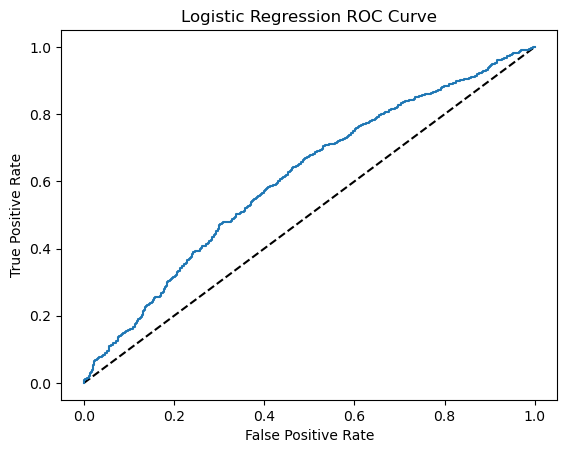

In [18]:
y_predict_probs = pipeline.predict_proba(X_test)[:,1]

new_y_test = y_test == 200
fpr, tpr, thresholds = roc_curve(new_y_test, y_predict_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


Lets do this on the entire test data to get predictions to submit into kaggle (train it with all of the training data wihout splitting it, X and y, and get the prediction csv like sample_submission.csv)

In [19]:
participants_test = pd.read_csv('../data/participants_test.csv')

In [20]:
df_2 = participants_test.merge(right = champion_mastery,
                                how = 'left',
                                on = ['summonerId', 'championId'])

In [21]:
df_2_array = np.array((df_2.groupby(['matchId','teamId'])
                           .sum(["summonerLevel", 'championLevel', 'championPoints', 'tokensEarned'])
                           .drop(columns=['participantId', 'summonerId', 'championId'])

                     ).unstack('teamId'))

In [22]:
col_names_2 = ['summonerLevel_100', 
                'summonerLevel_200',
                'championLevel_100', 
                'championLevel_200', 
                'championPoints_100',
                'championPoints_200', 
                'tokensEarned_100',
                'tokensEarned_200']

model_df_2 = (pd.DataFrame(data = df_2_array, columns = col_names_2)).merge(right = train_winners['winner'],
                                                                      how = 'left',
                                                                      left_index = True,
                                                                      right_index=True)

In [23]:
X_2 = model_df_2.drop(columns='winner').values


In [24]:
pipeline.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())])

In [25]:
sub_predictions = pipeline.predict(X_2)

In [26]:
np.arange(8000, 10000)

array([8000, 8001, 8002, ..., 9997, 9998, 9999])

In [27]:

submission_1 = pd.DataFrame(data = sub_predictions, columns=['winner'])
submission_1['matchId'] = np.arange(8000, 10000)


In [28]:
submission_1 = submission_1[submission_1.columns.to_list()[::-1]] 

In [29]:
submission_1.to_csv('../data/submission_2023-23-03_v01.csv',index=False)